In [14]:
# import statements
import numpy as np
import xarray as xr
import glob
import random
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import sys
import matplotlib.pyplot as plt
from scipy.stats import norm
sys.path.append('/home/disk/p/aodhan/SurfaceTrendLearing/MLExperiments/')
import TestingTrainingSplit_CV


# set path to model data
path_to_models = '/home/disk/pna2/aodhan/SurfaceTrendLearning/*_TrendMaps.nc'
ModelDataFiles = glob.glob(path_to_models)

# set path to ERA5 data
path_to_ERA5 = '/home/disk/pna2/aodhan/SurfaceTrendLearning/ERA5SkinTemp.nc'

# create land grid
land_shp_fname = shpreader.natural_earth(resolution='50m',
                                       category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)


# create grid for model data
sample_grid = xr.open_dataset(ModelDataFiles[0]) 
latitudes = sample_grid.Lat.to_numpy()
longitudes = sample_grid.Lon.to_numpy() - 180
weights = np.cos(np.deg2rad(latitudes))
latbounds = [32,40]

land_sea_mask = []
for x in longitudes:
    land_sea_mask_at_latitude = []
    for y in latitudes:
        land_sea_mask_at_latitude.append(TestingTrainingSplit_CV.is_land(x, y))
    land_sea_mask.append(land_sea_mask_at_latitude)
land_sea_mask = np.transpose(land_sea_mask)


# find model data global trends for all models and ensemble members
trends_array = []
for x in range(len(ModelDataFiles)):
    ModelDataFile = ModelDataFiles[x] 

    # we only need one model of testing for this CV iteration
    test_data = xr.open_dataset(ModelDataFile).to_array()[0]

    # reshape trends so that trend maps from different time periods and ensembles are treated equal
    NatTrends = test_data[:,0].to_numpy()[:,0]
    ForTrends = test_data[:,1].to_numpy()[:,0]
    TotalTrend = NatTrends + ForTrends

    # weight trend maps by cosine of latitude, you can use the weights from above
    TotalTrend_weighted = np.multiply(TotalTrend, weights[np.newaxis,:,np.newaxis])
    TotalTrendsTropicalMean = np.transpose(TestingTrainingSplit_CV.tropical_mean_trend(TotalTrend_weighted, land_sea_mask, weights, latbounds))
    SurfaceTrends = TotalTrendsTropicalMean[:,2]

    trends_array.append(SurfaceTrends)
trends_array = np.array(trends_array)



/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [15]:
print(latitudes[32:40])

[-8.75 -6.25 -3.75 -1.25  1.25  3.75  6.25  8.75]


In [16]:
from scipy import stats

# set path to ERA5 data
path_to_ERA5 = '/home/disk/pna2/aodhan/SurfaceTrendLearning/ERA5SkinTemp.nc'
# find ERA5 surface skin trend
ERA5_data = xr.open_dataset(path_to_ERA5)
latitudes_era = ERA5_data.latitude
longitudes_era = ERA5_data.longitude - 180
ts = ERA5_data['skt'].values
print(np.shape(ts))
ts = 1/2*(ts[:,1:,:]+ts[:,:-1,:])
ts_reshaped = np.reshape(ts, (228, 72*144))
trends_ts_reshaped = [stats.linregress(x=np.linspace(1,1.9,228),y=ts_reshaped[:,x])[0] for x in range(0, 10368)]
trends_ts = np.reshape(trends_ts_reshaped, (72,144))
TotalTrend_ERA5 = np.multiply(trends_ts, weights[:,np.newaxis])
TotalTrend_ERA5 = np.flip(TotalTrend_ERA5, axis=0)
TotalTrend_ERA5 = np.transpose(TestingTrainingSplit_CV.tropical_mean_trend(np.array([TotalTrend_ERA5]), land_sea_mask, weights, latbounds))
GlobalERA5TrendSknTemp = TotalTrend_ERA5[:,2]
#np.save('/home/disk/p/aodhan/SurfaceTrendLearing/FileCreators/ERA5Trend1996_2014', TotalTrend_ERA5)

# Get temperature anomaly timeseries data
WeightedTs = np.multiply(ts, weights[np.newaxis,:,np.newaxis])
WeightedFlippedTs = np.flip(WeightedTs, axis=1)
ERA5_surface_temp_data = np.transpose(TestingTrainingSplit_CV.tropical_mean_trend(WeightedFlippedTs, land_sea_mask, weights, latbounds))
ERA5_surface_land_temp = ERA5_surface_temp_data[:,2]
ERA5_surface_land_temp_cal = np.reshape(ERA5_surface_land_temp, (19,12))
ERA5_surface_land_temp_anoms = ERA5_surface_land_temp_cal - np.nanmean(ERA5_surface_land_temp_cal, axis=0)
ERA5_surface_land_temp_anoms_ts = np.reshape(ERA5_surface_land_temp_anoms, (19*12))

(228, 73, 144)


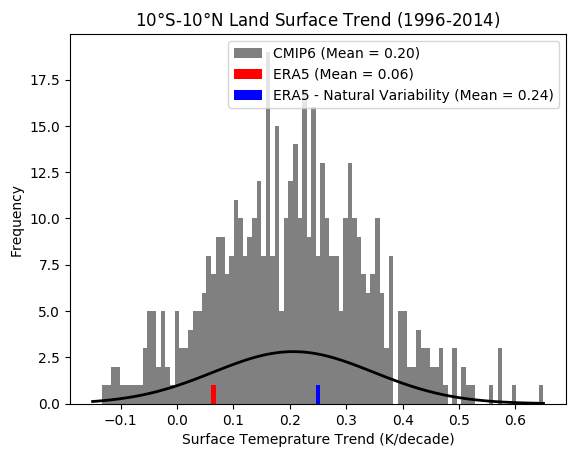

In [79]:
import matplotlib.pyplot as plt
from scipy.stats import norm

trends_array_flattened = []
for x in trends_array:
    #trends_array_flattened.append(np.nanmean(x))
    for ensemble in x:
        trends_array_flattened.append(ensemble)

# Fit a normal distribution to the data:
mu, std = norm.fit(trends_array_flattened)

# Plot the PDF.
xmin = -0.15
xmax = 0.65
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
hist = plt.hist(trends_array_flattened, bins=x, label='CMIP6 (Mean = {ERA5})'.format(ERA5=str(mu)[:4]), color='grey')
plt.plot(x, p, 'k', linewidth=2)
title = "10$\degree$S-10$\degree$N Land Surface Trend (1996-2014)"
plt.title(title)
ERA5 = plt.hist(GlobalERA5TrendSknTemp, bins=x, label='ERA5 (Mean = {ERA5})'.format(ERA5=str(GlobalERA5TrendSknTemp[0])[:4]), color='red')
SurfaceTrendNoNatural = GlobalERA5TrendSknTemp - -0.1987337976684661
ERA5_NoNatural = plt.hist(SurfaceTrendNoNatural, bins=x, label='ERA5 - Natural Variability (Mean = {ERA5})'.format(ERA5=str(GlobalERA5TrendSknTemp[0] - -0.1859750898274139)[:4]), color='blue')
plt.ylabel('Frequency')
plt.xlabel('Surface Temeprature Trend (K/decade)')
plt.legend()

(1996, 2014)

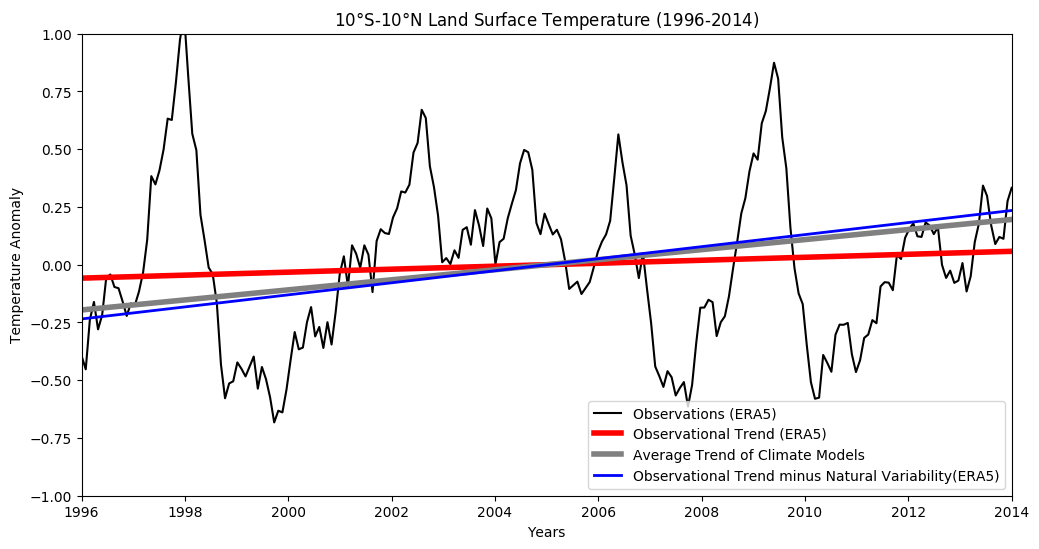

In [80]:
time = np.linspace(1996,2014,228)
plt.figure(figsize=(12,6))
plt.plot(time, ERA5_surface_land_temp_anoms_ts, label='Observations (ERA5)', color='black')
plt.plot(time, np.linspace(-.95,.95,228)*GlobalERA5TrendSknTemp, label='Observational Trend (ERA5)', color='red', linewidth=4)
plt.plot(time, np.linspace(-.95,.95,228)*mu, label='Average Trend of Climate Models', color='Grey', linewidth=4)
plt.plot(time, np.linspace(-.95,.95,228)*SurfaceTrendNoNatural, label='Observational Trend minus Natural Variability(ERA5)', color='Blue', linewidth=2)

plt.legend()
plt.title('10$\degree$S-10$\degree$N Land Surface Temperature (1996-2014)')
plt.ylabel('Temperature Anomaly')
plt.xlabel('Years')
plt.ylim(-1,1)
plt.xlim(1996,2014)


In [20]:
(GlobalERA5TrendSknTemp[0] - -0.1859750898274139)

0.24705980608613365

In [8]:
distance_from_mean = (GlobalERA5TrendSknTemp[0]) - mu
stds_from_mean = distance_from_mean/std
print(stds_from_mean)



-1.0774200382140124


(19, 72, 144)


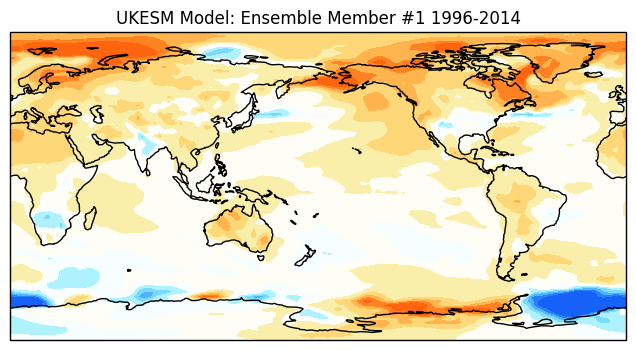

In [30]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-1.5, 1.5, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 1, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax.coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax.set_title('UKESM Model: Ensemble Member #1 1996-2014')
map_cyclic, lon = add_cyclic_point(np.reshape(TotalTrend[0], (72,144)), coord=lon_bins)
im = ax.contourf(lon, lat_bins, map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
print(np.shape(TotalTrend))

(19, 72, 144)


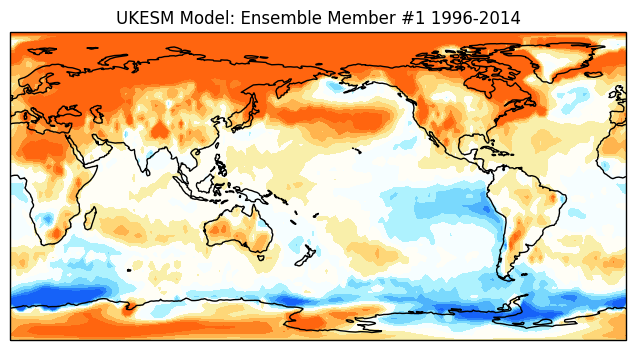

In [19]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap

# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

lim = np.linspace(-1.5, 1.5, 11)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
fig, ax = plt.subplots(1, 1, figsize=(9, 4), subplot_kw=subplot_kw)
####################################################################################
ax.coastlines()
#ax[0].set_extent([0.0, -1, -90.0, 90.0])
ax.set_title('UKESM Model: Ensemble Member #1 1996-2014')
map_cyclic, lon = add_cyclic_point(np.flip(trends_ts, axis=0), coord=lon_bins)
im = ax.contourf(lon, lat_bins, map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
print(np.shape(TotalTrend))

In [31]:
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'product_type': 'monthly_averaged_reanalysis',
        'variable': 'skin_temperature',
        'year': [
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2005', '2006', '2007',
            '2008', '2009', '2010',
            '2011', '2012', '2013',
            '2014',
        ],
        'month': [
            '01', '02', '03',
            '04', '05', '06',
            '07', '08', '09',
            '10', '11', '12',
        ],
        'time': '00:00',
        'grid': ['2.5', '2.5'],
        'format': 'netcdf',
    },
    )'/home/disk/pna2/aodhan/SurfaceTrendLearning/ERA5SkinTemp.nc'

2022-12-04 14:27:00,720 INFO Welcome to the CDS
2022-12-04 14:27:00,720 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/reanalysis-era5-single-levels-monthly-means
2022-12-04 14:27:00,896 INFO Request is queued
2022-12-04 14:27:02,069 INFO Request is running
2022-12-04 14:28:17,390 INFO Request is completed
2022-12-04 14:28:17,391 INFO Downloading https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data6/adaptor.mars.internal-1670192879.03851-11826-5-625ab3d2-3c78-4710-99ee-3a2a49ff754f.nc to /home/disk/pna2/aodhan/SurfaceTrendLearning/ERA5SkinTemp.nc (4.6M)
2022-12-04 14:28:21,357 INFO Download rate 1.2M/s   


Result(content_length=4796320,content_type=application/x-netcdf,location=https://download-0007-clone.copernicus-climate.eu/cache-compute-0007/cache/data6/adaptor.mars.internal-1670192879.03851-11826-5-625ab3d2-3c78-4710-99ee-3a2a49ff754f.nc)